# Identifying shipping lanes with radar <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Background
Being able to spot ships and shipping lanes from satellite imagery can be useful for gaining a holistic picture of maritime traffic.
The properties of radar data can be utilised to detect where ships appear over time, as well as highlighting the presence of shipping lanes.

When working with radar data, water commonly appears dark due to its relatively smooth surface resulting in very low backscatter, and consequently, low intensities are recorded by the satellite in both polarisation bands. 
However, if a large ship is on the water, the backscatter at the ship's location will be much higher than the water due to double-bounce scattering effects.

The ESA/EC Copernicus Sentinel-1 mission has been operating since April 2014. 
The two satellites (Sentinel-1A and 1B) have a frequent revisit time of 6 days.
This helps to build a large catalogue of observations that can be leveraged to identify shipping lanes.

This notebook is inspired by [this thread](https://twitter.com/thesheetztweetz/status/1374760229116682247?s=20) on Twitter in 2021. 

## Description
In this example, we attempt to identify shipping lanes around Suez Canal in Egypt by taking advantage of the fact that ships on the water result in a large radar backscatter signal.
This can be done by finding the maximum backscatter value of each pixel in Sentinel-1 images.
Computing the maximum value for many pixels is computationally expensive, so we make use of the parallel-computing library [Dask](https://docs.dask.org/en/latest/).

The worked example takes user through the code required to

1. Load Sentinel-1 backscatter image for an area of interest.
2. Calculate the maximum value for each pixel using Dask.
3. Visualise the maximum values to identify shipping lanes.
4. Calculate the minimum value for each pixel in `VV` polarisation in order to maskout land.  
5. Making use of notebook to detect and count ships following similar approach [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import dask
import datacube
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

sys.path.append("../Scripts")
from deafrica_tools.plotting import display_map,rgb
from deafrica_dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, mostcommon_crs

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Shipping_lane_identification")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42543 Dashboard: /user/neginm/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2021') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the coast of Gomoa Fetteh, Ghana.

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa/products/s1_rtc).

In [4]:
# Define the area of interest
lat = 30.09
lon = 32.57
buffer = 0.1

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

#timeframe
timerange = ('2020-03-23','2020-03-29')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
As part of specifying the load, the `dask_chunks` argument is used to tell Dask how to segement the data for parallelised computations (see the [xarray documentation](http://xarray.pydata.org/en/stable/dask.html)). 

In [6]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              group_by="solar_day",
              dask_chunks={'longitude':2000, 'latitude':2000},
              dtype='native'
             )
print(S1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 5 time steps as a dask array
<xarray.Dataset>
Dimensions:      (latitude: 1000, longitude: 1000, time: 5)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-23T15:56:43.986296 ... 2020-03...
  * latitude     (latitude) float64 30.19 30.19 30.19 ... 29.99 29.99 29.99
  * longitude    (longitude) float64 32.47 32.47 32.47 ... 32.67 32.67 32.67
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Visualise loaded data

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 

When working with radar backscatter, it is common to work with the data in units of decibels (dB), rather than digital number (DN) as measured by the satellite.
To convert from DN to dB in Sentinel-1 imagery, we use the following formula:

$$
\begin{aligned}
\text{dB} = 10 \times \log_{10}(\text{DN}).
\end{aligned}
$$

The code below visualises the *VH* band for the fifth timestep in the dataset:

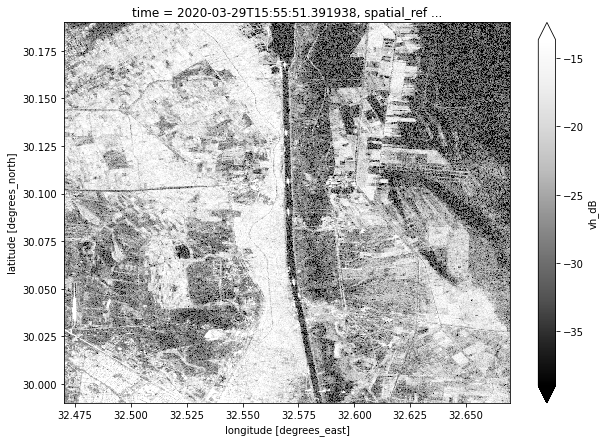

In [7]:
# Scale to plot data in decibels
S1["vh_dB"] = 10 * np.log10(S1.vh)

# Plot all VH observations for the year
S1.vh_dB.isel(time=4).plot(cmap="Greys_r", robust=True, figsize=(10,7))
plt.show()

## Calculating and plotting the maximum pixel value

After loading the data, we can calculate the maximum value for each pixel measured in decibels.
Note that the Dask operation will occur when attempting to plot the `vh_dB` band in the cell below.

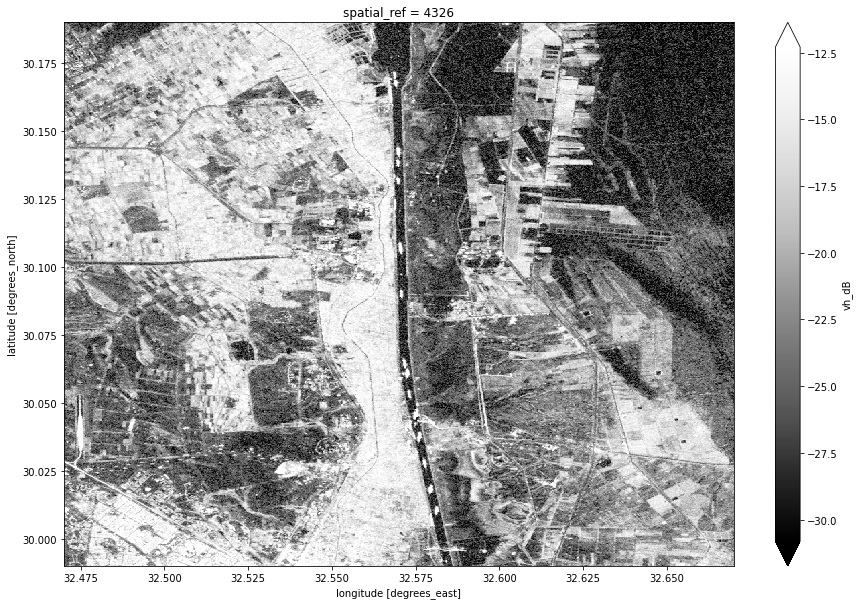

In [8]:
max_vh = S1.vh_dB.max(dim="time")
max_vh.plot.imshow(size=10, cmap="Greys_r", robust=True)
plt.show()

## Conclusion

The high contrast between the ships and the water can make for striking images.
Fortunately, processing with Dask makes it possible to make these computationally-intensive images in under a minute, even for very large areas.
DE Africa Sentinel-1 dataset is processed by Sinergise Sentinel Hub using ESA Sentinel-1 GRD as input and available for 2019, 2020 and early 2021. 

## Next steps

When you are done, return to the "Set up analysis" cell, modify some values (e.g. `latitude` and `longitude`) and rerun the analysis.

There are a number of key ports covered by Sentinel-1 data in Africa. 
The available data can be viewed on the [DEAfrica Explorer](https://explorer.digitalearth.africa/products/s1_rtc), but we also list the latitude and longitude coordinates for a few key ports below.

### South Africa  
**Port of Durban **

```
latitude = -29.87
longitude = 31.03
```

### Tanzania  
**Port of Dar Es Salaam ** 

```
latitude = -6.83
longitude = 39.29
```

### Morocco
**Port de Tanger Med **

```
latitude = 35.86
longitude = -5.53
```

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [9]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


**Last Tested:**

In [10]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-06-16'